## Decision Trees Models

This script aims to observe and draw conclusions about the variability and correlations of the data as a function of different noise levels in the data simulation.

We will train and evaluate Extra Trees models, a type of Decision Tree with additional randomization. We will see how they perform by training the models with the established data and determine which one has the greatest predictive and explanatory capacity by analyzing the importance of the variables in the decision tree.

Although it does not establish causality, it is a good model to identify the variables that most statistically influence the classification of Age at Menarche.


### Carga y Diccionario de Datos

In [1]:
from pycaret.classification import predict_model, create_model, pull, setup
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [ ]:
# List to store the DataFrames
dataframes_sin_log = []

# Read Excel files from 1 to 5
for i in range(1, 6):
    filename = f'Pregnancy_{i}.xlsx'
    try:
        df = pd.read_excel(filename)
        dataframes_sin_log.append(df)
        print(f"File read successfully: {filename}")
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error reading {filename}: {e}")

for i, df in enumerate(dataframes_sin_log):
    if 'PCBtotal3' in df.columns:
        df.rename(columns={'PCBtotal3': 'PCB'}, inplace=True)
        print(f"Renamed column in DataFrame {i+1}")
    else:
        print(f"'PCBtotal3' not found in DataFrame {i+1}")

dataframes_sin_log_sin_id = [df.drop(columns=['idnum'], errors='ignore') for df in dataframes_sin_log]


Archivo leído correctamente: Pregnancy_1.xlsx
Archivo leído correctamente: Pregnancy_2.xlsx
Archivo leído correctamente: Pregnancy_3.xlsx
Archivo leído correctamente: Pregnancy_4.xlsx
Archivo leído correctamente: Pregnancy_5.xlsx
Renombrada columna en DataFrame 1
Renombrada columna en DataFrame 2
Renombrada columna en DataFrame 3
Renombrada columna en DataFrame 4
Renombrada columna en DataFrame 5


In [ ]:
# List of columns to transform
log_columns = ['pfhxs', 'pfoa', 'pfos', 'pfna', 'v_44DDT', 'v_44DDE', 'HCB', 'bHCH', 'PCB']

# Create the new list with deep copies
dataframes_con_log = []

for i, df in enumerate(dataframes_sin_log):
    # Make a copy of the original DataFrame
    df_log = df.copy()
    
    # Apply logarithmic transformation only if the column exists and is numeric
    for col in log_columns:
        if col in df_log.columns:
            # To avoid log(0) or negative values, replace 0 with NaN before applying log
            df_log[col] = np.log(df_log[col].replace(0, np.nan))
    
    dataframes_con_log.append(df_log)
    print(f"Log transformation applied to DataFrame {i+1}")


Transformación log aplicada al DataFrame 1
Transformación log aplicada al DataFrame 2
Transformación log aplicada al DataFrame 3
Transformación log aplicada al DataFrame 4
Transformación log aplicada al DataFrame 5


In [ ]:
def entrenar_modelos_con_pycaret(lista_dfs, nombre_lista, target_variable, model_name, model_params, session_id=123, fold=5, verbose=False):
    trained_models = []

    for i, df in enumerate(lista_dfs):
        print(f"\n------ Processing DataFrame {i+1} from {nombre_lista} ------")

        # Drop rows without target
        df_model = df.dropna(subset=[target_variable]).copy()

        # PyCaret setup
        setup_kwargs = {
            'data': df_model,
            'target': target_variable,
            'session_id': session_id,
            'fold': fold,
            'verbose': verbose,
            'use_gpu': False
        }

        setup(**setup_kwargs)

        # Create custom model according to the name
        if model_name == 'xgboost':
            model_obj = XGBClassifier(**model_params)
        elif model_name == 'lightgbm':
            model_obj = LGBMClassifier(**model_params)
        elif model_name == 'rf':
            model_obj = RandomForestClassifier(**model_params)
        else:
            model_obj = model_name  # Assume it's a string without params or a prepared object

        model = create_model(model_obj)
        trained_models.append(model)

    return trained_models


### Extra Trees Classifier

In [ ]:
%%capture
params_et = {
    'n_estimators': 200,
    'criterion': 'gini',
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'bootstrap': False,
    'random_state': 123,
    'n_jobs': -1
}


target_variable = 'edad_menarquia'

modelos_sin_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='et',
    params_modelo=params_et
)

modelos_con_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='et',
    params_modelo=params_et
)


### Lightgbm

In [6]:
%%capture
params_lgbm = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_leaves': 31,
    'min_child_samples': 20,
    'random_state': 123,
    'n_jobs': -1
}

modelos_lgbm_sin_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='lightgbm',
    params_modelo=params_lgbm
)

modelos_lgbm_con_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='lightgbm',
    params_modelo=params_lgbm
)


### XGBoost

In [7]:
%%capture
params_xgb = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 123,
    'n_jobs': -1
}

modelos_xgb_sin_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='xgboost',
    params_modelo=params_xgb
)

modelos_xgb_con_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='xgboost',
    params_modelo=params_xgb
)


### Random Forest

In [8]:
%%capture
params_rf = {
    'n_estimators': 200,
    'max_depth': 3,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 123,
    'n_jobs': -1
}

modelos_rf_sin_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_sin_log,
    nombre_lista="sin log",
    target_variable=target_variable,
    model_name='rf',
    params_modelo=params_rf
)

modelos_rf_con_log = entrenar_modelos_con_pycaret(
    lista_dfs=dataframes_con_log,
    nombre_lista="con log",
    target_variable=target_variable,
    model_name='rf',
    params_modelo=params_rf
)


In [ ]:
def evaluar_modelos(modelos, nombre_lista):
    resultados = []

    for i, modelo in enumerate(modelos):
        print(f"\n📊 Evaluando modelo {i+1} de {nombre_lista}...")
        
        # Ejecutar predicción sobre la validación interna
        predict_model(modelo)
        
        # Obtener el DataFrame de métricas (lo devuelve `pull()` tras `predict_model`)
        resultados_df = pull()
        resultados_df["modelo"] = f"{nombre_lista}_{i+1}"
        resultados.append(resultados_df)

    # Concatenar todos los resultados
    resumen = pd.concat(resultados, ignore_index=True)
    return resumen

In [10]:
%%capture
resumen_sin_log = evaluar_modelos(modelos_sin_log, "sin_log")
resumen_con_log = evaluar_modelos(modelos_con_log, "con_log")

resumen_lightgbm_sin_log = evaluar_modelos(modelos_lgbm_sin_log, "sin_log")
resumen_lightgbm_con_log = evaluar_modelos(modelos_lgbm_con_log, "con_log")

resumen_xgb_sin_log = evaluar_modelos(modelos_xgb_sin_log, "sin_log")
resumen_xgb_con_log = evaluar_modelos(modelos_xgb_con_log, "con_log")

resumen_rf_sin_log = evaluar_modelos(modelos_rf_sin_log, "sin_log")
resumen_rf_con_log = evaluar_modelos(modelos_rf_con_log, "con_log")

In [11]:

# Opcional: ver todo junto
resumen_total_et = pd.concat([resumen_sin_log, resumen_con_log], ignore_index=True)

# Mostrar resultados agrupados por modelo
print(resumen_total_et)

                    Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Extra Trees Classifier    0.6754  0.8849  0.6754  0.6952  0.6762  0.5786   
1  Extra Trees Classifier    0.6203  0.8718  0.6203  0.6677  0.6251  0.5043   
2  Extra Trees Classifier    0.6348  0.8418  0.6348  0.6459  0.6369  0.5302   
3  Extra Trees Classifier    0.6087  0.8440  0.6087  0.6206  0.6041  0.4925   
4  Extra Trees Classifier    0.5565  0.8243  0.5565  0.5717  0.5563  0.4323   
5  Extra Trees Classifier    0.9101  0.9915  0.9101  0.9139  0.9096  0.8844   
6  Extra Trees Classifier    0.9797  0.9993  0.9797  0.9803  0.9798  0.9740   
7  Extra Trees Classifier    0.9739  0.9995  0.9739  0.9737  0.9734  0.9665   
8  Extra Trees Classifier    0.9913  0.9996  0.9913  0.9914  0.9913  0.9889   
9  Extra Trees Classifier    0.9942  1.0000  0.9942  0.9943  0.9942  0.9926   

      MCC     modelo  
0  0.5829  sin_log_1  
1  0.5155  sin_log_2  
2  0.5316  sin_log_3  
3  0.4988  sin_log_4  
4  0.4354  sin_

In [12]:
resumen_total_lightgbm = pd.concat([resumen_lightgbm_sin_log, resumen_lightgbm_con_log], ignore_index=True)
print(resumen_total_lightgbm)

                             Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Light Gradient Boosting Machine    0.4261  0.7650  0.4261  0.4441  0.3770   
1  Light Gradient Boosting Machine    0.4348  0.7346  0.4348  0.4869  0.4097   
2  Light Gradient Boosting Machine    0.4232  0.7334  0.4232  0.4938  0.4257   
3  Light Gradient Boosting Machine    0.4087  0.7051  0.4087  0.4850  0.3768   
4  Light Gradient Boosting Machine    0.2522  0.6913  0.2522  0.5303  0.2018   
5  Light Gradient Boosting Machine    0.7826  0.9584  0.7826  0.7850  0.7733   
6  Light Gradient Boosting Machine    0.8812  0.9799  0.8812  0.8751  0.8713   
7  Light Gradient Boosting Machine    0.9217  0.9927  0.9217  0.9205  0.9178   
8  Light Gradient Boosting Machine    0.9420  0.9955  0.9420  0.9436  0.9407   
9  Light Gradient Boosting Machine    0.9391  0.9958  0.9391  0.9377  0.9345   

    Kappa     MCC     modelo  
0  0.2235  0.2584  sin_log_1  
1  0.2770  0.2910  sin_log_2  
2  0.2777  0.2865  sin_log

In [13]:
resumen_total_xgb = pd.concat([resumen_xgb_sin_log, resumen_xgb_con_log], ignore_index=True)
print(resumen_total_xgb)

                       Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Extreme Gradient Boosting    0.4928  0.7959  0.4928  0.5412  0.4639   
1  Extreme Gradient Boosting    0.4841  0.7431  0.4841  0.5688  0.4606   
2  Extreme Gradient Boosting    0.4290  0.7411  0.4290  0.5541  0.4517   
3  Extreme Gradient Boosting    0.4029  0.7279  0.4029  0.5569  0.4230   
4  Extreme Gradient Boosting    0.3275  0.7489  0.3275  0.4792  0.3093   
5  Extreme Gradient Boosting    0.8000  0.9669  0.8000  0.8147  0.7932   
6  Extreme Gradient Boosting    0.8667  0.9823  0.8667  0.8665  0.8570   
7  Extreme Gradient Boosting    0.9159  0.9903  0.9159  0.9128  0.9134   
8  Extreme Gradient Boosting    0.9362  0.9952  0.9362  0.9334  0.9341   
9  Extreme Gradient Boosting    0.9304  0.9954  0.9304  0.9282  0.9283   

    Kappa     MCC     modelo  
0  0.3284  0.3560  sin_log_1  
1  0.3376  0.3574  sin_log_2  
2  0.3030  0.3251  sin_log_3  
3  0.2708  0.2961  sin_log_4  
4  0.2031  0.2328  sin_log_5  

In [14]:
resumen_total_rf = pd.concat([resumen_rf_sin_log, resumen_rf_con_log], ignore_index=True)
print(resumen_total_rf)

                      Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Random Forest Classifier    0.3855  0.7651  0.3855  0.5652  0.3005  0.1456   
1  Random Forest Classifier    0.3623  0.7587  0.3623  0.4260  0.2471  0.1053   
2  Random Forest Classifier    0.3594  0.7643  0.3594  0.4087  0.2531  0.1024   
3  Random Forest Classifier    0.3536  0.7470  0.3536  0.4098  0.2543  0.0949   
4  Random Forest Classifier    0.3507  0.7606  0.3507  0.2803  0.2549  0.0988   
5  Random Forest Classifier    0.4406  0.7937  0.4406  0.5587  0.3656  0.2282   
6  Random Forest Classifier    0.4464  0.8256  0.4464  0.5740  0.3672  0.2341   
7  Random Forest Classifier    0.4609  0.8458  0.4609  0.5837  0.3873  0.2562   
8  Random Forest Classifier    0.4464  0.8492  0.4464  0.5926  0.3765  0.2334   
9  Random Forest Classifier    0.4493  0.8443  0.4493  0.5890  0.3829  0.2383   

      MCC     modelo  
0  0.2139  sin_log_1  
1  0.1985  sin_log_2  
2  0.1876  sin_log_3  
3  0.1699  sin_l

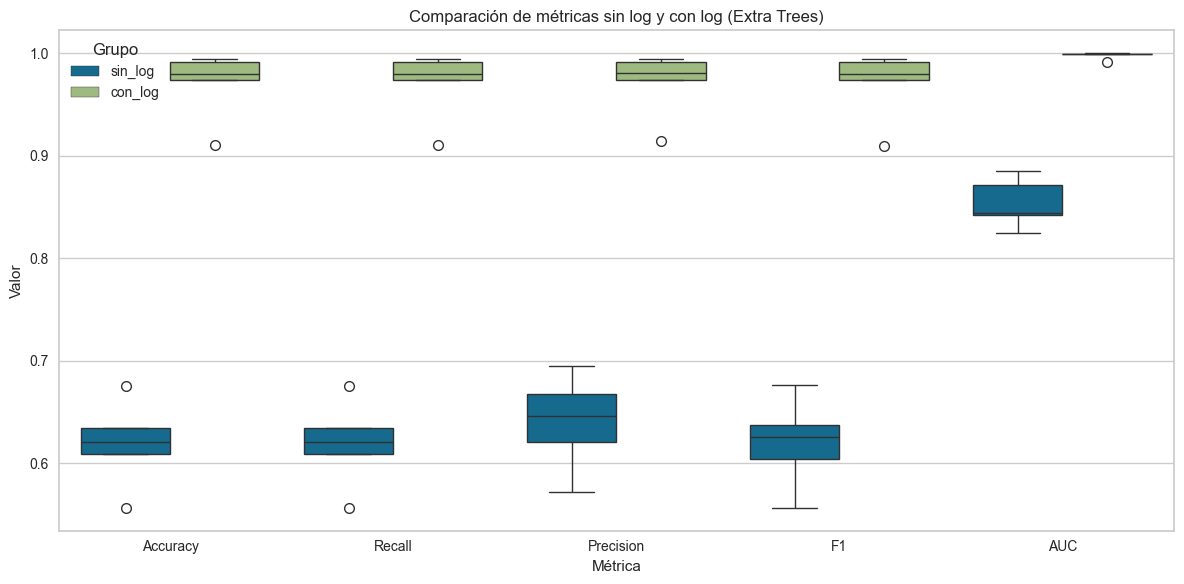

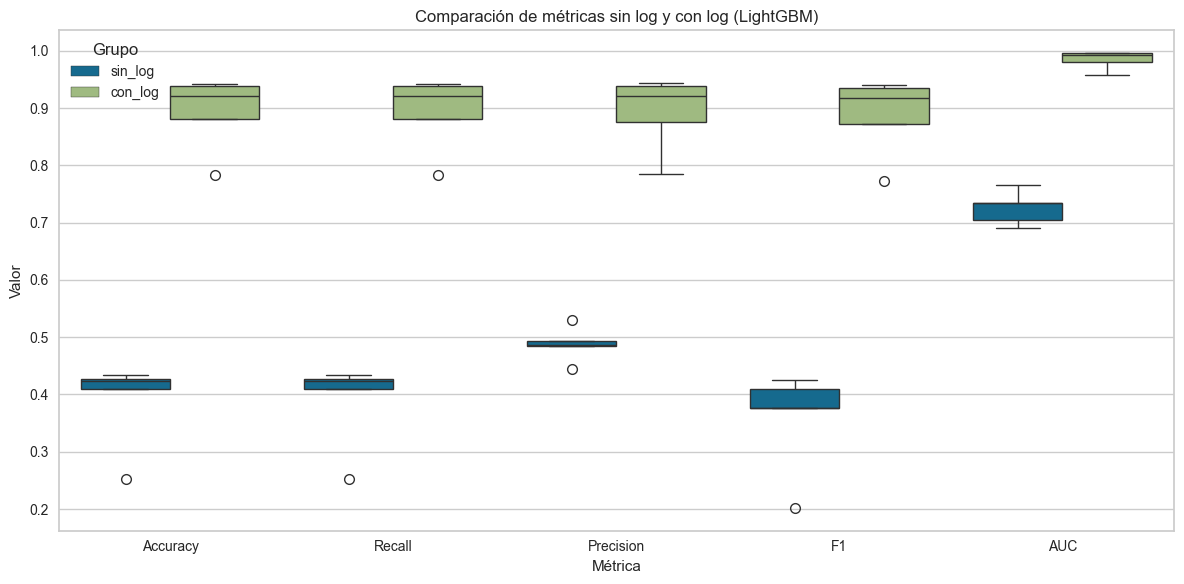

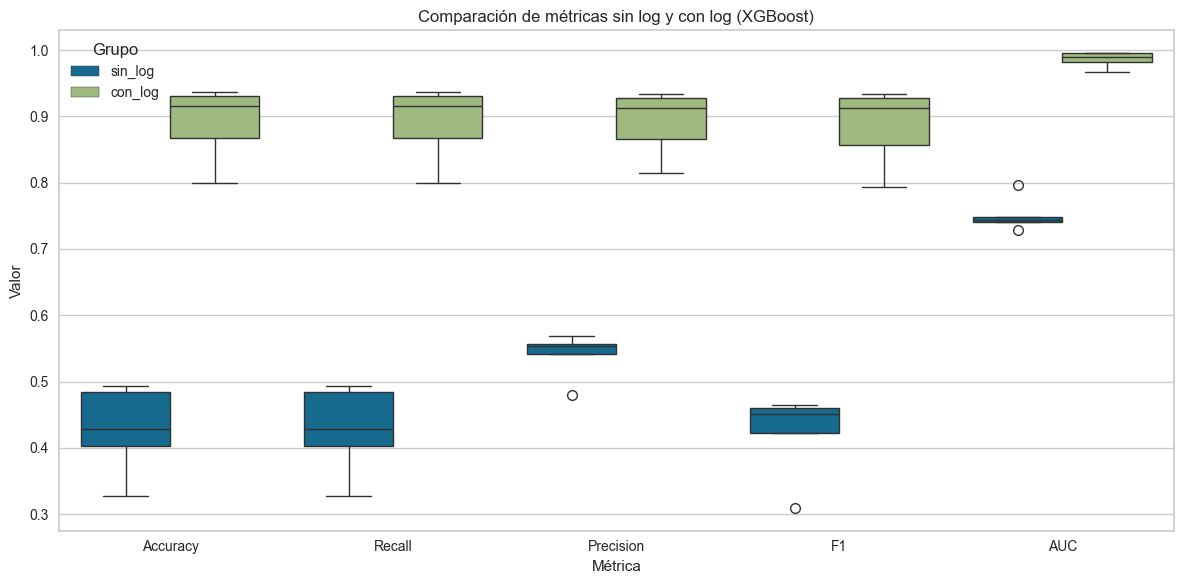

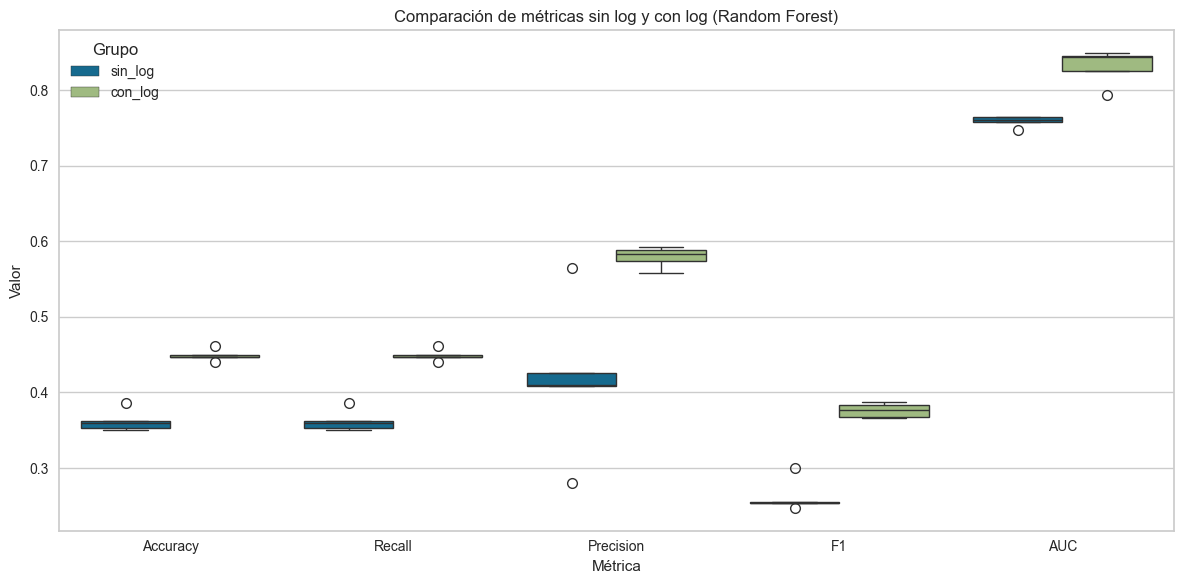

In [ ]:
# Renombrar columnas si es necesario
resumen_total_et = resumen_total_et.rename(columns={"Prec.": "Precision"})
resumen_total_xgb = resumen_total_xgb.rename(columns={"Prec.": "Precision"})
resumen_total_lightgbm = resumen_total_lightgbm.rename(columns={"Prec.": "Precision"})
resumen_total_rf = resumen_total_rf.rename(columns={"Prec.": "Precision"})

# Función para generar gráfico por modelo
def graficar_boxplot_metricas(resumen_total, nombre_modelo):
    resumen_largo = resumen_total.melt(
        id_vars=["modelo"],
        value_vars=["Accuracy", "Recall", "Precision", "F1", "AUC"],
        var_name="Métrica",
        value_name="Valor"
    )

    resumen_largo["grupo"] = resumen_largo["modelo"].apply(lambda x: "sin_log" if "sin_log" in x else "con_log")

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=resumen_largo, x="Métrica", y="Valor", hue="grupo")
    plt.title(f"Comparison of metrics without log and with log ({nombre_modelo})")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()
    return resumen_largo

# Generar gráficos para cada modelo
resumen_largos = []
resumen_largos.append(graficar_boxplot_metricas(resumen_total_et, "Extra Trees"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_lightgbm, "LightGBM"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_xgb, "XGBoost"))
resumen_largos.append(graficar_boxplot_metricas(resumen_total_rf, "Random Forest"))


In [ ]:
for resumen_largo in resumen_largos:
    # Agrupar por grupo y métrica, y calcular la media
    resumen_largo["grupo"] = resumen_largo["modelo"].apply(lambda x: "sin_log" if "sin_log" in x else "con_log")
    resumen_largo["Métrica"] = resumen_largo["Métrica"].str.replace(" ", "_")
    resumen_largo["Valor"] = resumen_largo["Valor"].astype(float)
resumen_medias = resumen_largo.groupby(["grupo", "Métrica"])["Valor"].mean().unstack()
print("Promedio de métricas por grupo:")
print(resumen_medias.round(3))


Promedio de métricas por grupo:
Métrica    AUC  Accuracy     F1  Precision  Recall
grupo                                             
con_log  0.832     0.449  0.376      0.580   0.449
sin_log  0.759     0.362  0.262      0.418   0.362


In [17]:
from pycaret.classification import evaluate_model
evaluate_model(modelos_con_log[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [18]:
evaluate_model(modelos_rf_con_log[3])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…